In [1]:
from isotools import Transcriptome
from isotools import __version__ as isotools_version
from isotools._utils import _filter_event

import os
from pathlib import Path
import logging
from collections import Counter
from urllib.request import urlretrieve
import itertools
from tqdm.notebook import tqdm_notebook as tqdm

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isootools version {isotools_version}')

INFO:This is isootools version 0.2.11rc1


In [2]:
# define the paths for reference and annotation files
genome='/project/hfa_work/ceraolo/theco/ref/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta'
anno='/project/hfa_work/ceraolo/theco/ref/gencode.v29.primary_assembly.annotation_UCSC_names_sorted'

In [3]:
try:
    isoseq=Transcriptome.load("./theco_isotools.pkl")
    
except FileNotFoundError:    
    try:
        isoseq=Transcriptome.from_reference(anno+".isotools.pkl")
        
    except:
        isoseq=Transcriptome.from_reference(anno+".gtf.gz")
        isoseq.save_reference(anno+'.isotools.pkl')

INFO:loading transcriptome from ./theco_isotools.pkl


In [4]:
stbl=isoseq.sample_table

In [5]:
groups={}

for stype in ('cell line', 'in vitro differentiated cells', 'primary cell', 'tissue'):
    groups[stype]=list(stbl.name[stbl.sample_type==stype])

In [6]:
def eval_trid(df):
    df.priA_priB_trID=[eval(e) for e in df.priA_priB_trID]
    df.priA_altB_trID=[eval(e) for e in df.priA_altB_trID]
    df.altA_priB_trID=[eval(e) for e in df.altA_priB_trID]
    df.altA_altB_trID=[eval(e) for e in df.altA_altB_trID]
    pass

In [7]:
tbl_path="./tables/sample_type/"
files=[x.name for x in Path(tbl_path).iterdir()]

In [8]:
if not all([f in files for f in ('coor_cell_line.csv', 'coor_invitro_diff.csv', 'coor_primary_cell.csv', 'coor_tissue.csv')]):
    coor_cell_line=isoseq.coordination_test(samples=groups["cell line"], query="not NOVEL_GENE",
                                            event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_cell_line.to_csv("./tables/sample_type/coor_cell_line.csv",index=False)
    
    coor_invitro_diff=isoseq.coordination_test(samples=groups["in vitro differentiated cells"],query="not NOVEL_GENE",
                                        event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_invitro_diff.to_csv("./tables/sample_type/coor_invitro_diff.csv",index=False)
    
    coor_primary_cell=isoseq.coordination_test(samples=groups["primary cell"],query="not NOVEL_GENE",
                                           event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_primary_cell.to_csv("./tables/sample_type/coor_primary_cell.csv",index=False)
    
    coor_tissue=isoseq.coordination_test(samples=groups["tissue"],query="not NOVEL_GENE",
                                           event_type=("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),test="fisher")
    coor_tissue.to_csv("./tables/sample_type/coor_tissue.csv",index=False)
    
else:
    coor_cell_line=pd.read_csv("./tables/sample_type/coor_cell_line.csv")
    eval_trid(coor_cell_line)
    
    coor_invitro_diff=pd.read_csv("./tables/sample_type/coor_invitro_diff.csv")
    eval_trid(coor_invitro_diff)
    
    coor_primary_cell=pd.read_csv("./tables/sample_type/coor_primary_cell.csv")
    eval_trid(coor_primary_cell)
    
    coor_tissue=pd.read_csv("./tables/sample_type/coor_tissue.csv")
    eval_trid(coor_tissue)

In [9]:
tabl_dict={"cell_line":coor_cell_line,"invitro_diff":coor_invitro_diff,
           "primary_cell":coor_primary_cell, "tissue":coor_tissue}

# Volcano Plots

In [25]:
figures="figures/gene_stats/"
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 200
plt.style.use("seaborn-whitegrid")

In [13]:
def types_stats(df):
    
    pairs=list(itertools.combinations_with_replacement(("ES","3AS", "5AS","IR","ME", "TSS", "PAS"),2))
    count_dict={}
    
    for t in pairs:
        
        df_p=[p for p in zip(df.ase1_type,df.ase2_type)]
        counts=[(p==t or p[::-1]==t) for p in df_p]
        count_dict[t]=sum(counts)
        
    tot=df.shape[0]
    
    res=[(n/tot,n,p) for p,n in count_dict.items()]
    res.sort(reverse=True)
    return res

In [69]:
def volcano_plot(df,ax = None,sig=0.05,sigor=1.5,tag="(add a tag)",normalized=False):
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(10,5))
    
    palette=sns.color_palette().as_hex()
    colors=[]
    
    for i,r in df.iterrows():
        if r.adj_p_value>=sig or abs(r.log2OR)<=sigor:
            colors.append(palette[7])
        else:
            colors.append(palette[0])

            
    x=np.array(df.log2OR)
    
    if normalized == True:
        sigor-=np.mean(x)
        sigor/=np.std(x)
        x-=np.mean(x)
        x/=np.std(x)
        
        y=np.array(df.adj_p_value)
        
        sig-=np.mean(y)
        sig/=np.std(y)
        
        y-=np.mean(y)
        y/=np.std(y)
        y=-np.log10(y)
        title=f"Normalized volcano plot of {tag}"
    else:
        y=np.array(-np.log10(df.adj_p_value))
        title=f"Volcano plot of {tag}"
    
    ax.scatter(x,y,c=colors)
    ax.axhline(y=-np.log10(sig),color="red",linestyle='dotted',label=f"adj_p_value = {sig}")
    ax.axvline(x=sigor,color="green",linestyle='dotted',label=f"log2OR threshold = {sigor}")
    ax.axvline(x=-sigor,color="green",linestyle='dotted')



    
    ax.set_title(title,fontsize=13+7)
    ax.set_ylabel("-log10(p_value)",fontsize=12)
    ax.set_xlabel("log2OR",fontsize=12)
    ax.legend(frameon=True,fontsize=12)

In [18]:
df=tabl_dict["cell_line"]

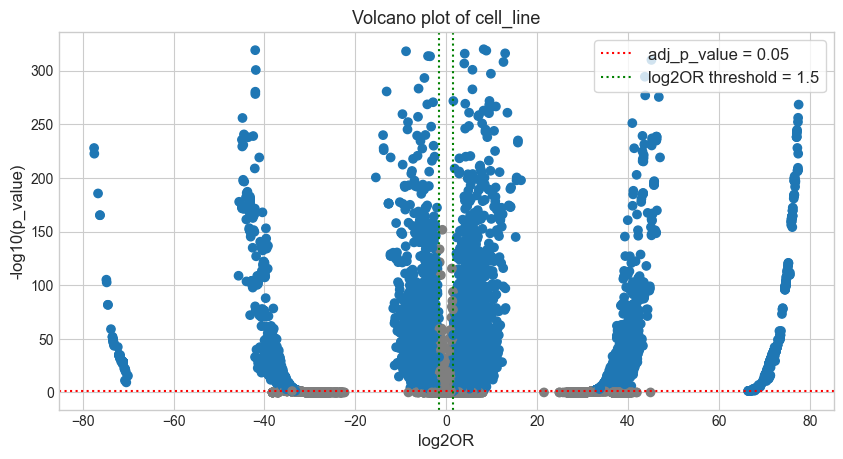

In [29]:
volcano_plot(df,tag="cell_line")

/scratch/local/ipykernel_117280/1154017710.py:31: RuntimeWarning: invalid value encountered in log10
  y=-np.log10(y)
/scratch/local/ipykernel_117280/1154017710.py:38: RuntimeWarning: invalid value encountered in log10
  ax.axhline(y=-np.log10(sig),color="red",linestyle='dotted',label=f"adj_p_value = {sig}")


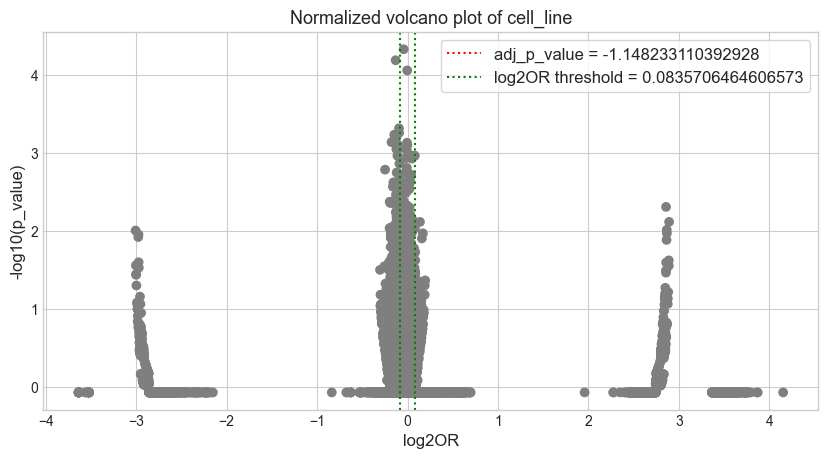

In [30]:
volcano_plot(df,tag="cell_line",normalized=True)

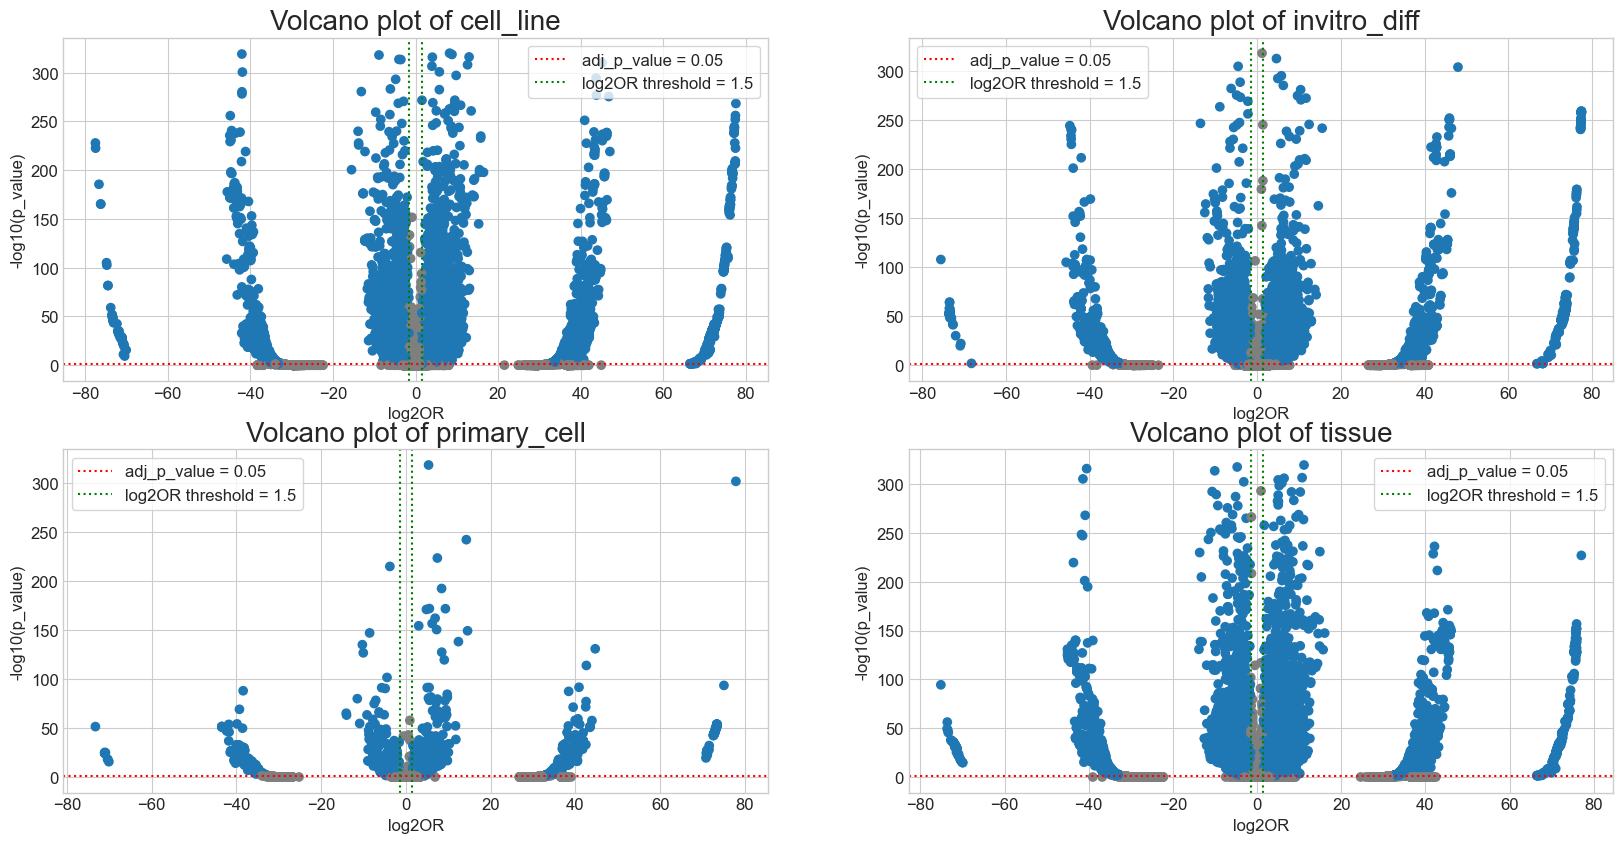

In [70]:
fig,axs=plt.subplots(figsize=(10*2,5*2),ncols=2,nrows=2)
indeces=[(0,0),(0,1),(1,0),(1,1)]
i=0

for k,tab in tabl_dict.items():
    volcano_plot(tab,tag=k,ax=axs[indeces[i]])
    i+=1
    
plt.savefig(figures+"volcano_plot_grid.png")

Make a general dataframe

In [31]:
colnames={e:[] for e in df.keys()}

In [32]:
dfg=pd.DataFrame(colnames)

for t,df in tabl_dict.items():
    df["type"]=t
    dfg=pd.concat([dfg,df])
dfg=dfg.reset_index(drop=True)

/pkg/python-3.9.12-0/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/scratch/local/ipykernel_117280/4248749452.py:5: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figures+"volcano_plot_ensemble.png")
/pkg/python-3.9.12-0/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


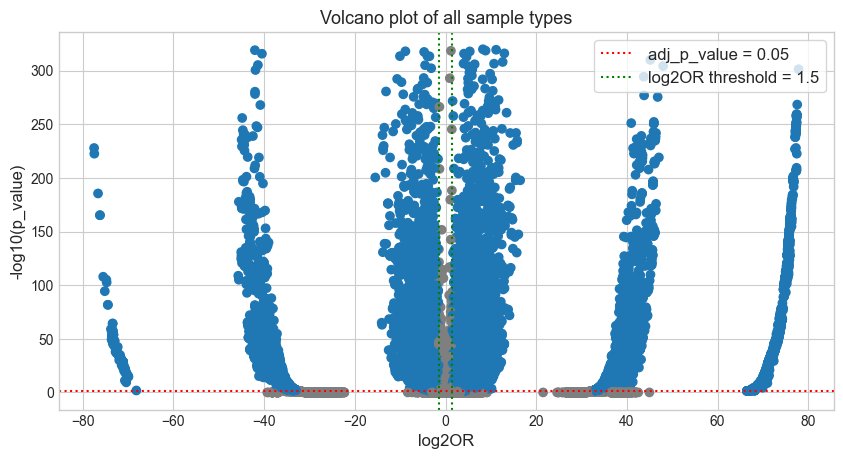

In [33]:
fig,ax=plt.subplots(figsize=(10,5))

volcano_plot(dfg,tag="all sample types",ax=ax)
    
plt.savefig(figures+"volcano_plot_ensemble.png")

In [34]:
g1=dfg[abs(dfg.log2OR)<20]
g2=dfg[(abs(dfg.log2OR)<60) & (abs(dfg.log2OR)>20)]
g3=dfg[abs(dfg.log2OR)>60]

In [45]:
plt.rcParams["font.size"] = 12 #default was 10

In [58]:
def piechart(df,color_dict=None,ax=None,sig=0.05,title=""):
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(10,5))
        
    sig_df=df[df.adj_p_value<sig]
    sig_df.reset_index(drop=True)
    
    dfstats=types_stats(sig_df)
    
    sizes=[e[0] for e in dfstats if e[0]>0.02]
    labels=["-".join(e[2]) for e in dfstats if e[0]>0.02]
    
    sizes.append(1-sum(sizes))
    labels.append("others")
    
    if color_dict is not None:
        colors=[color_dict[l] for l in labels]
    
    ax.pie(sizes,labels=labels,autopct='%1.1f%%',colors=colors)
    ax.set_title(title,fontsize=18)


In [36]:
labels=['IR-IR', 'TSS-PAS', 'IR-TSS', 'IR-PAS', '3AS-IR', '5AS-IR', '3AS-PAS', 'ES-3AS', '5AS-TSS',
        '3AS-5AS', 'TSS-TSS', 'PAS-PAS', 'ME-TSS', 'ME-PAS', 'ME-ME', 'IR-ME','ES-TSS', 'ES-PAS',
        'ES-ME', 'ES-IR', 'ES-ES', 'ES-5AS', '5AS-PAS','5AS-ME', '5AS-5AS','3AS-TSS', '3AS-ME',
        '3AS-3AS',"others"]

palette=sns.color_palette().as_hex()

color_dict={}

for i in range(len(labels)):
    color_dict[labels[i]]=palette[i%10]


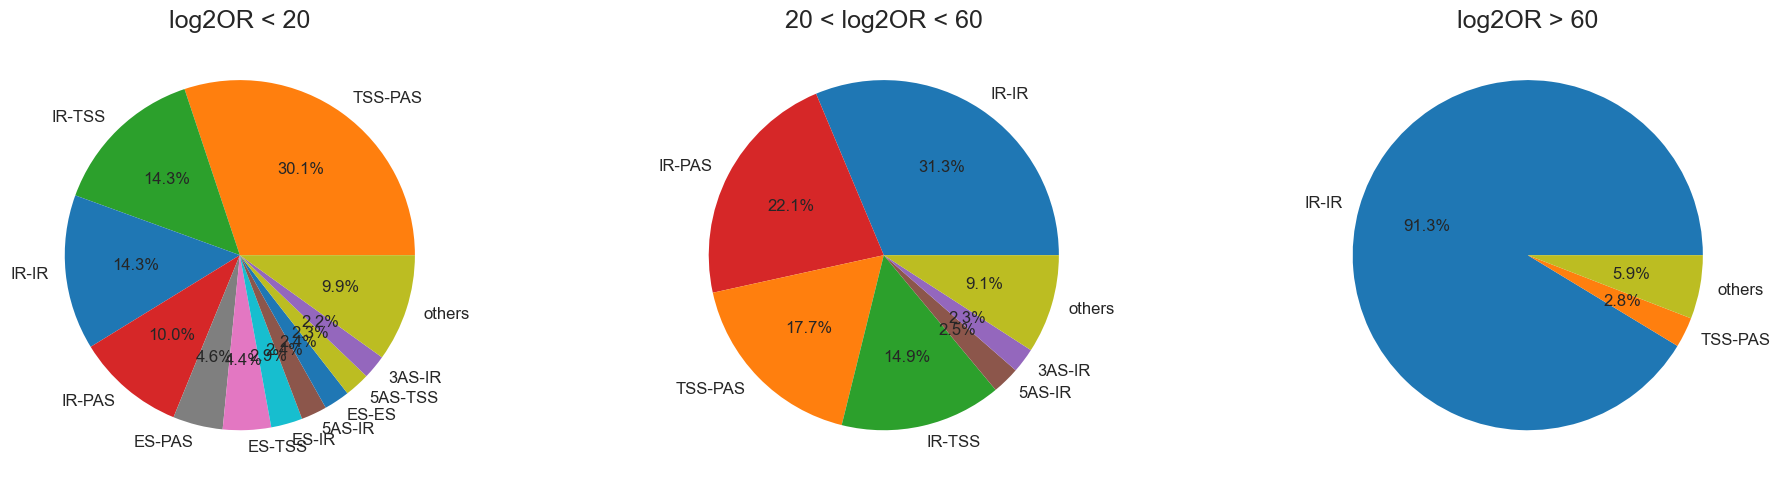

In [59]:
fig,axs=plt.subplots(figsize=(10*2,5),ncols=3)

gs=(g1,g2,g3)
titles=["log2OR < 20", "20 < log2OR < 60", "log2OR > 60"]

for i in range(3):
    piechart(gs[i],ax=axs[i],color_dict=color_dict,title=titles[i])
fig.tight_layout()

plt.savefig(figures+"log2OR_piechart_sig.png")

In [60]:
def plot_ave_cont(df,ax=None,sig=0.05):
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(7,6))
        
    sig_df=df[df.adj_p_value<sig]
    sig_df.reset_index(drop=True)
        
    all_i=[e for e in range(sig_df.shape[0])]
    i=random.sample(all_i,1000)
    df_s=sig_df.iloc[i,:]
    stats=df_s.mean()
    cont=np.zeros((2,2))
    
    cont[0,0]=stats.priA_priB
    cont[1,0]=stats.priA_altB
    cont[0,1]=stats.altA_priB
    cont[1,1]=stats.altA_altB
    
    cont=pd.DataFrame(cont)
    cont.columns=["priA","altA"]
    cont.index=["priB","altB"]
    
    sns.heatmap(cont,annot=True,ax=ax,center=20,cmap="coolwarm",fmt=".0f")

/scratch/local/ipykernel_117280/2356103903.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats=df_s.mean()
/scratch/local/ipykernel_117280/2356103903.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats=df_s.mean()
/scratch/local/ipykernel_117280/2356103903.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats=df_s.mean()


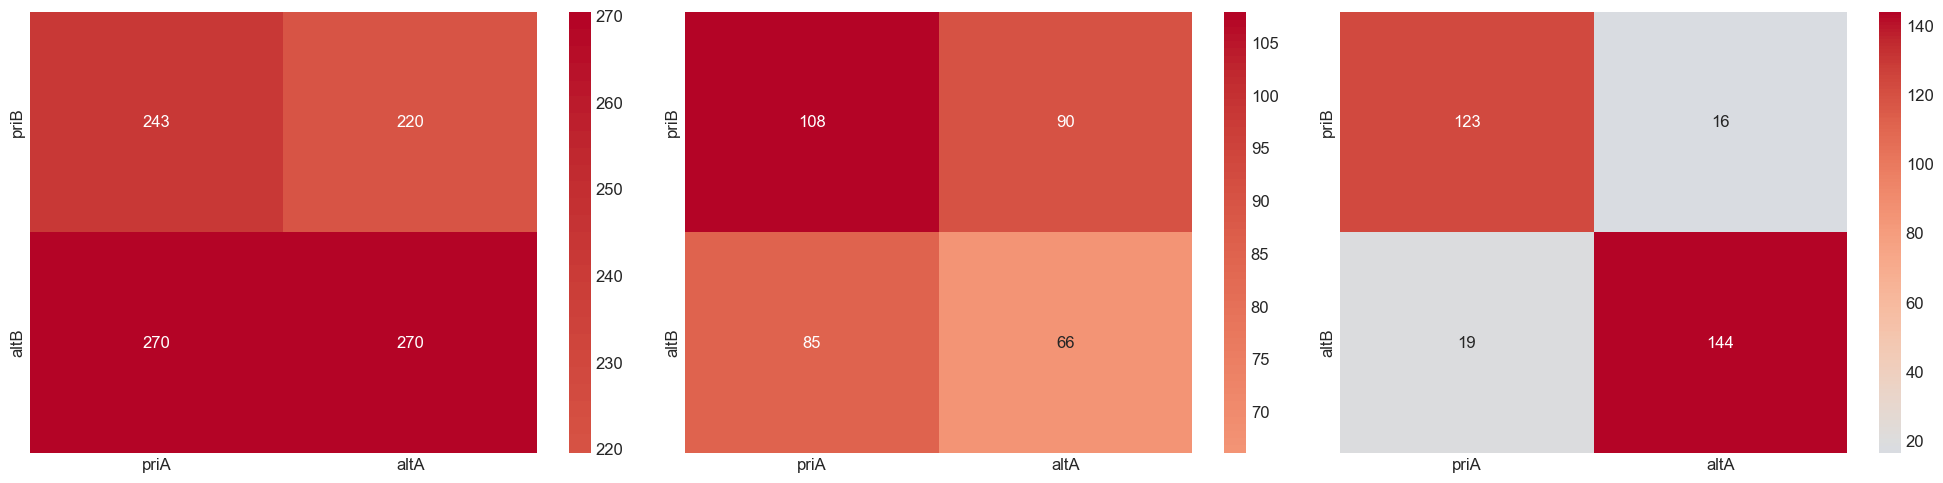

In [62]:
fig,axs=plt.subplots(figsize=(7*3-1,6-1),ncols=3)

gs=(g1,g2,g3)

for i in range(3):
    plot_ave_cont(gs[i],ax=axs[i])

fig.tight_layout()

plt.savefig(figures+"ave_cont_sig.png")

In [112]:
def plor_dist(df,ax=None,tag=""):
    
    if ax is None:
        fig,axs=plt.subplots(figsize=(10*1.5,5),ncols=2)
        
    palette=sns.color_palette().as_hex()
    
    x1=np.array(df.adj_p_value)
    x2=np.array(df.log2OR)

    sns.kdeplot(x1,ax=axs[0],color=palette[0],fill=True)
    axs[0].set_title(f"KDE of the adjusted p-values in {tag}",fontsize=20)

    sns.kdeplot(x2,ax=axs[1],color=palette[1],fill=True)
    axs[1].set_title(f"KDE of the log odds ratio in {tag}",fontsize=20)
    
    if ax is None:
        fig.tight_layout()

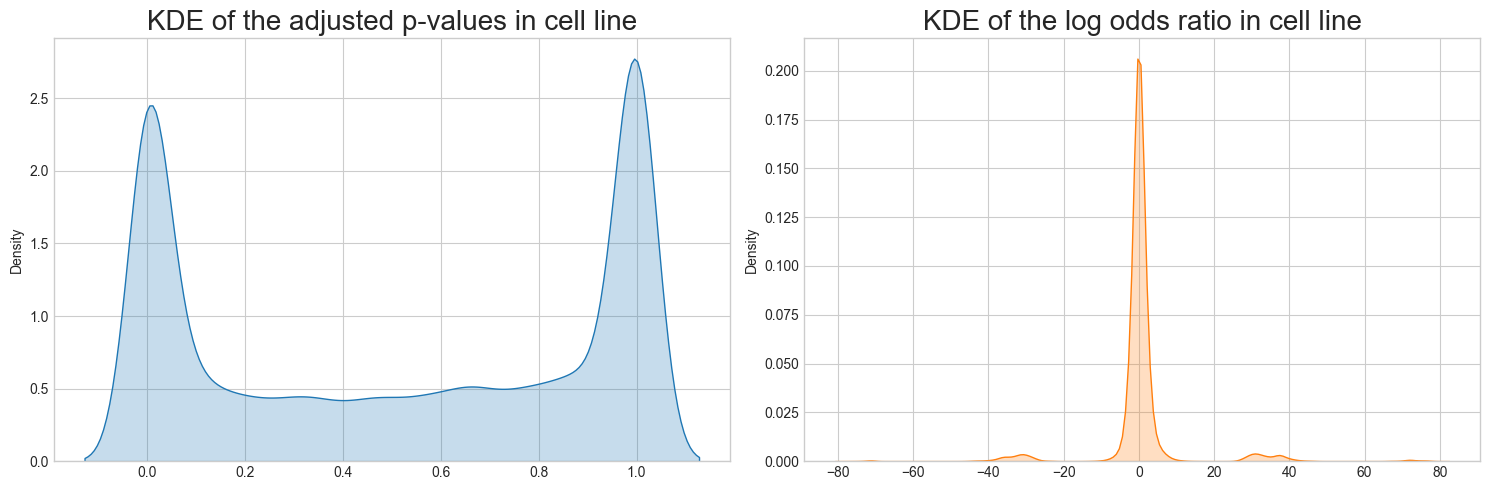

In [113]:
plor_dist(df,tag="cell line")

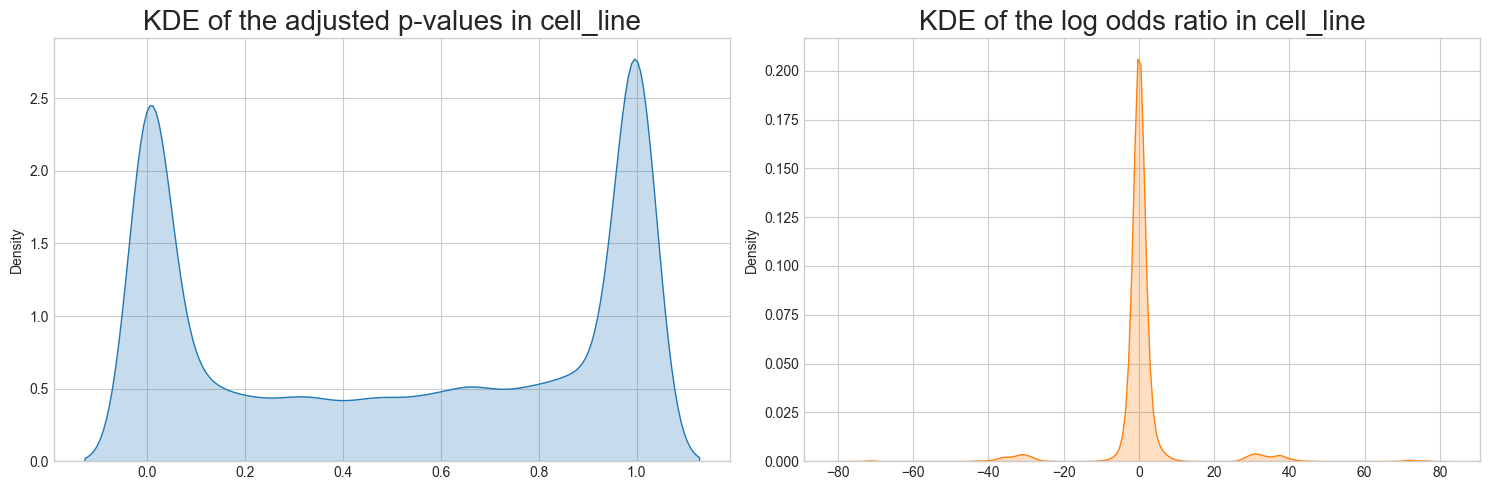

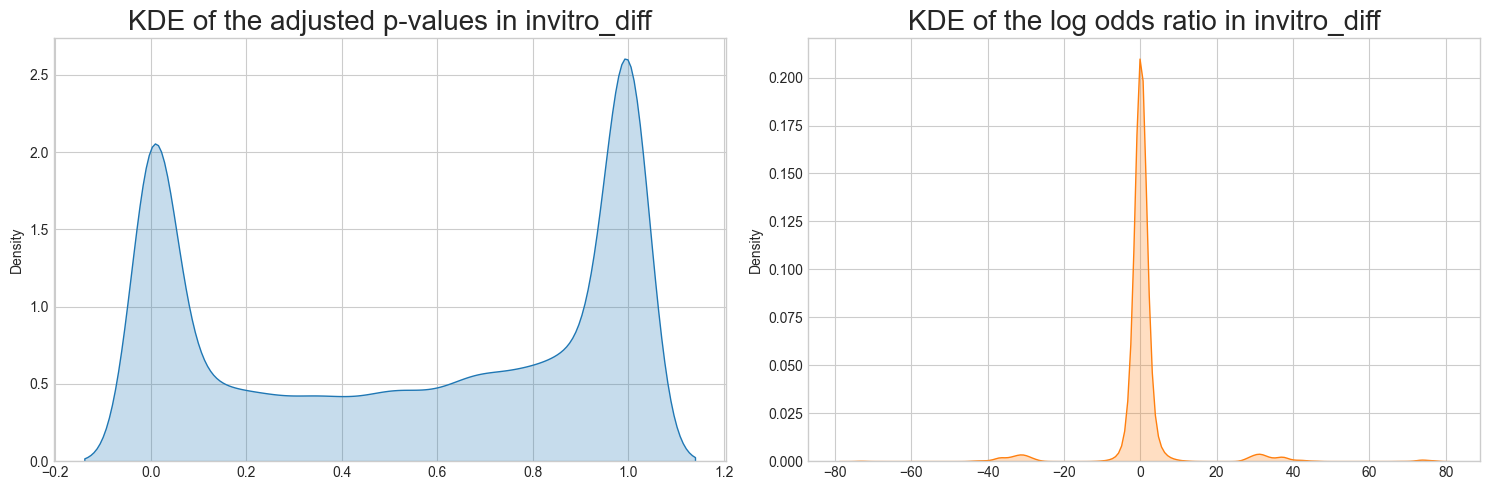

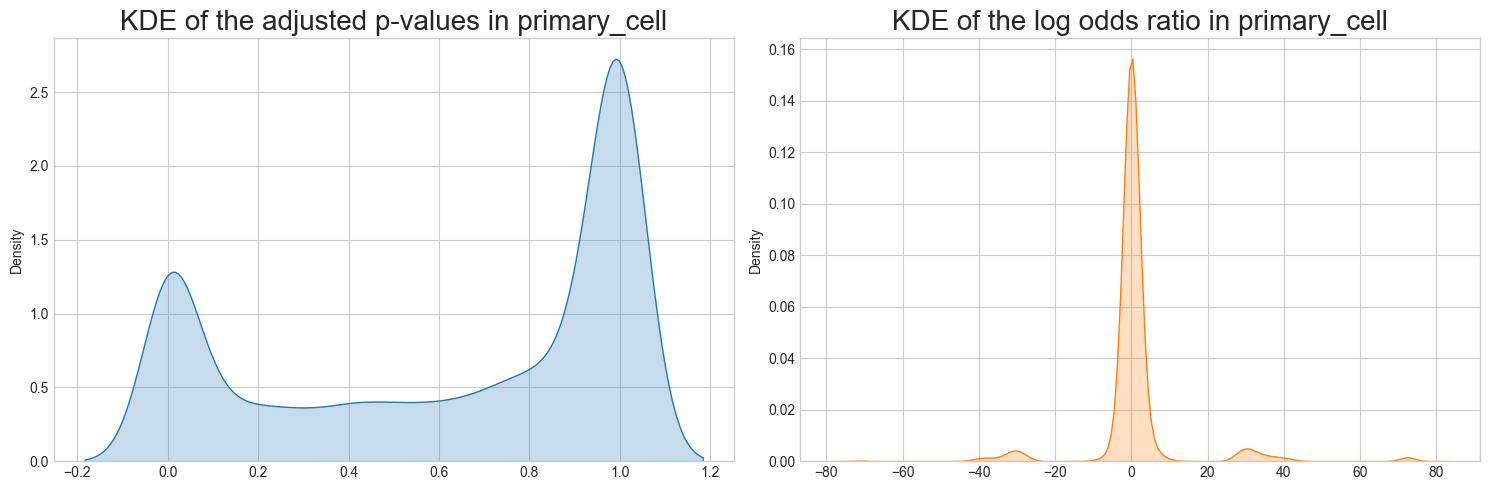

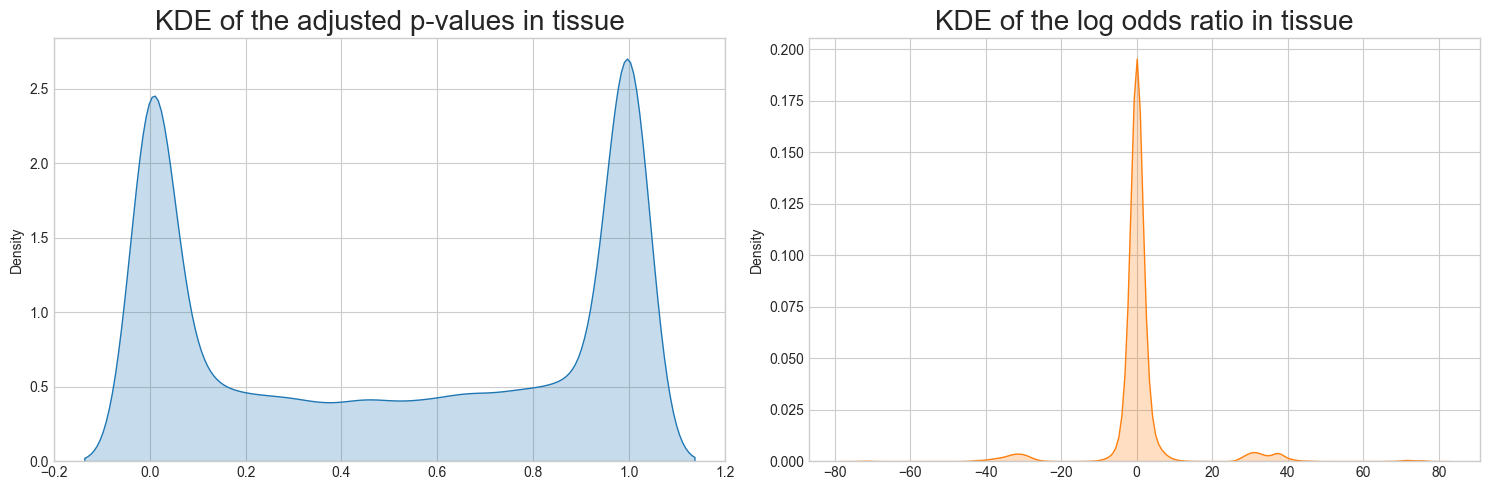

In [114]:
for k,tab in tabl_dict.items():
    plor_dist(tab,tag=k)
    plt.savefig(figures+f"plor_dist_{k}.png")

In [79]:
g1_sig=g1[(g1.adj_p_value>0.05) & (abs(g1.log2OR)>1.5)]
g1_sig["abs_log2OR"]=abs(g1_sig.log2OR)
g1_sig.sort_values(by="abs_log2OR")


/scratch/local/ipykernel_117280/3504002783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g1_sig["abs_log2OR"]=abs(g1_sig.log2OR)


,gene_id,gene_name,strand,ase1_type,ase2_type,ase1_start,ase1_end,ase2_start,ase2_end,p_value,...,priA_priB,priA_altB,altA_priB,altA_altB,priA_priB_trID,priA_altB_trID,altA_priB_trID,altA_altB_trID,type,abs_log2OR
126514,ENSG00000005889.15,ZFX,+,ES,PAS,24149794.0,24161714.0,24210192.0,24216089.0,0.265567,...,25.0,2.0,137.0,31.0,"[12, 5, 392, 345, 305, 154, 174, 140, 49, 42, 27]","[51, 30]","[4, 31, 23, 46, 408, 247, 14, 435, 377, 277, 1...","[19, 44, 26, 462, 458, 396, 315, 309, 153, 121...",invitro_diff,1.500020
39717,ENSG00000079999.13,KEAP1,-,5AS,TSS,10489368.0,10491576.0,10502696.0,10502838.0,0.045881,...,40.0,66.0,12.0,7.0,"[30, 7, 63]","[10, 165]","[32, 118, 44, 105, 89, 46, 164, 131, 120, 71, 67]","[38, 96, 12, 152, 51]",cell_line,1.500074
92023,ENSG00000138640.14,FAM13A,-,ES,ME,88790627.0,88851019.0,88906462.0,89020459.0,0.449123,...,1.0,22.0,9.0,70.0,"[310, 387, 252]","[86, 288, 326, 423, 477, 476, 464, 421, 389, 3...","[80, 445, 414, 400, 356, 316, 306, 294]","[313, 89, 308, 143, 111, 274, 424, 346, 263, 1...",invitro_diff,1.500074
42649,ENSG00000226688.6,ENTPD1-AS1,-,5AS,PAS,95876660.0,95897557.0,95869241.0,95875666.0,0.253096,...,2.0,66.0,15.0,175.0,"[168, 103, 210, 189, 90, 83, 43]","[86, 9, 34, 1, 116, 115, 64, 31, 22, 276, 236,...","[74, 60, 201, 160, 135, 134, 108, 17, 16, 266,...","[8, 13, 7, 5, 111, 110, 61, 11, 0, 4, 122, 35,...",cell_line,1.500074
162533,ENSG00000188130.13,MAPK12,-,3AS,TSS,50256646.0,50257081.0,50261166.0,50261797.0,0.026511,...,198.0,30.0,21.0,9.0,"[1, 114, 473, 465, 530, 508, 443, 330, 721, 54...","[82, 449, 739, 471, 421, 327, 204, 697, 604, 2...","[93, 84, 727, 726, 716, 552, 503, 458, 411, 39...","[176, 734, 483, 467, 332, 695, 689, 688, 685, ...",tissue,1.500074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178483,ENSG00000122852.14,SFTPA1,+,IR,IR,79611389.0,79611581.0,79613266.0,79613743.0,1.000000,...,0.0,1.0,0.0,296.0,[],[647],[],"[74, 161, 206, 374, 178, 415, 530, 278, 549]",tissue,8.209453
53391,ENSG00000152061.23,RABGAP1L,+,IR,PAS,174957549.0,174957890.0,174244297.0,174246355.0,1.000000,...,1.0,0.0,324.0,0.0,"[179, 474, 400, 234, 189]",[],"[7, 49, 160, 31, 204, 174, 388, 337, 112, 8, 4...",[],cell_line,8.339850
166549,ENSG00000096968.13,JAK2,+,IR,TSS,4985630.0,4985939.0,5044393.0,5044520.0,1.000000,...,346.0,0.0,1.0,0.0,"[4, 6, 218, 11, 5, 18, 114, 46, 13, 16, 3, 61,...",[],[184],[],tissue,8.434628
154985,ENSG00000137857.17,DUOX1,+,IR,TSS,45151248.0,45151873.0,45155819.0,45155929.0,1.000000,...,508.0,0.0,1.0,0.0,"[53, 70, 48, 79, 77, 16, 88, 43, 83, 91, 52, 2...",[],[216],[],tissue,8.988685


In [74]:
(np.array(g1.adj_p_value>0.05))

array([False,  True,  True, ...,  True,  True,  True])